## Gradient Descent vs Dwave Quantum Annealing, Simulated Annealing

### Solving a toy binary linear regression model with MSE loss

In [1]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's install with dimod and neal
if IN_COLAB:
    !pip install dwave-ocean-sdk

If run locally, install dwave ocean sdk follow the instruction here:
https://docs.ocean.dwavesys.com/en/stable/overview/install.html
    

In [1]:
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.linalg as la
import time

# **Define the toy regression problem here**

Input = X with shape (n,d); n data, each data has d dimensions


Output = Y with shape (n,1) 


Weights = w with shape (d,1), due to the limitation of dwave, w here are binary

In [28]:
def generate_data(num_samples, num_features, noise):
    W = np.random.randint(2, size=num_features)
    X = 10*np.random.randn(num_samples, num_features)
    Y = np.matmul(X,W)+noise*np.random.randn(num_samples)
    return X, Y, W


X, Y, beta_star = generate_data(200,20,50)

## Regression as an optimization problem, MSE loss

First we would write this problem as optimization problem, given X,Y, we want find the optimal w that minimize the mean squred error


$$
\min_{\mathbf{w}} 1/2\mathbf{w}^\top \mathbf{X}^\top \mathbf{X} \mathbf{w}\ - \mathbf{w}^\top \mathbf{x}^\top \mathbf{Y} + 1/2  \mathbf{Y}^\top \mathbf{Y}
\\
\mathbf{w} \in \{0,1 \}
$$

In [44]:
from sklearn.metrics import mean_squared_error
def loss(beta):
    prediction = X.dot(beta)
    return mean_squared_error(Y,prediction)

# Solve it using GD

In [280]:

### just GD for linear regression
def OLS(X, Y, max_iter):
    n, d = X.shape
    w, v = np.linalg.eig(np.matmul(np.transpose(X),X))
    L    = np.max(w)
    betas= []

    XTX  = np.matmul(np.transpose(X),X)
    XTY  = np.matmul(np.transpose(X),Y)
        
    beta = np.zeros(d)
    betas.append(beta)
    betas.append(beta-(1/L)*(np.matmul(XTX, beta) - XTY))
    i=0
#     while (np.linalg.norm(betas[i]-beta_star))>0.9:
#     print(np.linalg.norm(betas[i]-beta))
    for i in range(max_iter):
        beta         = beta-(1/L)*(np.matmul(XTX, beta) - XTY)
        betas.append(beta) 
        i+=1
#         print(beta)

    return beta, betas

In [284]:
t1 = time.time()
beta_hat, betas = OLS(X,Y,1000)
print("The error rate is {}%".format(round(100*np.mean(np.abs(beta_hat-beta_star)),3)))
print("Time used for GD is {}s".format(time.time()-t1))

The error rate is 29.697%
Time used for GD is 0.010241031646728516s


In [285]:
def binary_project(u):
    v = np.array(u)

    v[v<0.5] = 0
    v[v>=0.5] = 1

    return v


### just GD for linear regression
def binary_OLS(X, Y, max_iter):
    n, d = X.shape
    w, v = np.linalg.eig(np.matmul(np.transpose(X),X))
    L    = np.max(w)
    betas= []

    XTX  = np.matmul(np.transpose(X),X)
    XTY  = np.matmul(np.transpose(X),Y)
        
    beta = np.zeros(d)
    betas.append(beta)
    betas.append(beta-(1/L)*(np.matmul(XTX, beta) - XTY))
    i=0

    for i in range(max_iter):
        beta         = binary_project(beta-(1/L)*(np.matmul(XTX, beta) - XTY))
        betas.append(beta) 
        i+=1
#         print(beta)

    return beta, betas

In [286]:
import time
t1 = time.time()
beta_hat, betas = binary_OLS(X,Y,1000)
print("The error rate is {}%".format(round(100*np.mean(np.abs(beta_hat-beta_star)),3)))
print("Time used for projected GD is {}s".format(time.time()-t1))

The error rate is 15.0%
Time used for projected GD is 0.014467000961303711s


## Now let's try to use Dwave solvers
Need convert problem into QUBO first

#### QUBO formulation
We define a QUBO as the following optimization problem:
$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E(G)} Q_{ij}x_i x_j + \sum_{i \in V(G)}Q_{ii}x_i + c_Q = \min_{x \in \{0,1 \}^n}  x^\top Q x + c_Q
$$
where we optimize over binary variables $x \in \{ 0,1 \}^n$, on a constrained graph $G(V,E)$ defined by an adjacency matrix $Q$. We also include an arbitrary offset  $c_Q$.

In [240]:
#### get the linear term and qudratic term 
XTX  = np.matmul(np.transpose(X),X)
XTY  = np.matmul(np.transpose(X),Y)
d =len(X[0])


## based on MSE loss, linear term in w: XTY
linear = {}
for i in range(1,d+1):
    linear[i] = -XTY[i-1]

## based on MSE loss, quadratic term in w: XTX
quadratic = {}
for i in range(1,d+1):
    for j in range(1,d+1):
        quadratic[(i,j)] = 0.5*XTX[i-1][j-1]
        
        
import dimod
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite


offset = 0.0
vartype = dimod.BINARY

## create binary quadratic model
bqm = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)

## Simulated annealing

Simulated Annealing can be run without having a dwave account or valid API token


Only need install dwave ocean (shown at the beginning of this notebook)

In [278]:
t2 = time.time()
sampler = dimod.SimulatedAnnealingSampler()
sample_set = sampler.sample(bqm)
t3 = time.time()
print("Using SimulatedAnnlearingSampler()")
print(sample_set)


## sample_set is an unique type containing all the info for the solver, please see below link for more info 
## https://docs.ocean.dwavesys.com/en/stable/_modules/dimod/sampleset.html

Using SimulatedAnnlearingSampler()
   1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 20        energy num_oc.
0  1  1  0  0  1  1  1  1  0  0  0  0  1  1  1  1 ...  1 -141493.59328       1
1  1  1  0  0  1  1  1  1  0  0  0  0  1  1  1  1 ...  1 -141493.59328       1
2  1  1  0  0  1  1  1  1  0  0  0  0  1  1  1  1 ...  1 -141493.59328       1
3  1  1  0  0  1  1  1  1  0  0  0  0  1  1  1  1 ...  1 -141493.59328       1
4  1  1  0  0  1  1  1  1  0  0  0  0  1  1  1  1 ...  1 -141493.59328       1
5  1  1  0  0  1  1  1  1  0  0  0  0  1  1  1  1 ...  1 -141493.59328       1
6  1  1  0  0  1  1  1  1  0  0  0  0  1  1  1  1 ...  1 -141493.59328       1
7  1  1  0  0  1  1  1  1  0  0  0  0  1  1  1  1 ...  1 -141493.59328       1
8  1  1  0  0  1  1  1  1  0  0  0  0  1  1  1  1 ...  1 -141493.59328       1
9  1  1  0  0  1  1  1  1  0  0  0  0  1  1  1  1 ...  1 -141493.59328       1
['BINARY', 10 rows, 10 samples, 20 variables]


In [287]:
prediction = sample_set.record[-1][0]
print("The error rate is {}%".format(round(100*np.mean(np.abs(beta_hat-prediction)),3)))
print("Time used for Simulated Annealing is {}s".format(t3-t2))

The error rate is 15.0%
Time used for Simulated Annealing is 3.2589669227600098s


## Quantum Annealing!
In order to run this, need have a dwave account and set up API following step 1 and step 2

step 1. Make sure you first has a dwave account registered at https://cloud.dwavesys.com/leap/login/ 


step 2. Then follow the instructions here to set up your API at https://www.youtube.com/watch?v=SjUI_GmH_5As

If set up your dwave on google colab on google colab instead of terminal, will have similiar process as the shown in the link in step 2. (such as setting up the token etc, but on google colab now instead of terminal)


In [30]:
# Let's setup the D-Wave connection
#### input your dwave acccount token when running this on colab (during the run of dwave setup)
if IN_COLAB:
    !dwave setup

In [32]:
!dwave ping

Using endpoint: https://cloud.dwavesys.com/sapi/
Using solver: hybrid_binary_quadratic_model_version2
Error: Sampling error: SolverFailureError("Problems with 'bqm' type must provide the 'time_limit' param") (code: 10)


In [288]:
import dwave
import sys, os
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import dwave_networkx as dnx
from dwave.system import (DWaveSampler, EmbeddingComposite,
                          FixedEmbeddingComposite)
from pprint import pprint
api_key = os.getenv('DEV-588880b24e7d7e6eca43200d26555c6c05d431ed')

# DWave Credentials
dwave_solver = os.getenv('DW_2000Q_6')

### copy your own token
# own_token = ''
# api_key = os.getenv(own_token)

## note that you can copy your token from your dwave account dashboard
## or for MACbook, the default path for API token file is /Users/your_name/Library/Application Support/dwave/dwave.conf

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [289]:
## Time is given in mircoseconds
sample_set = sampler.sample(bqm)
sample_set

## sample_set is an unique type containing all the info for the solver, please see below link for more info 
## https://docs.ocean.dwavesys.com/en/stable/_modules/dimod/sampleset.html

SampleSet(rec.array([([1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1], -141493.59327996, 1, 0.)],
          dtype=[('sample', 'i1', (20,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], {'timing': {'qpu_sampling_time': 96, 'qpu_anneal_time_per_sample': 20, 'qpu_readout_time_per_sample': 55, 'qpu_access_time': 26148, 'qpu_access_overhead_time': 7403, 'qpu_programming_time': 26051, 'qpu_delay_time_per_sample': 21, 'total_post_processing_time': 111, 'post_processing_overhead_time': 111}, 'problem_id': '2c04c31b-c7b9-4c2c-8ae1-cc92cb01e250'}, 'BINARY')

In [291]:
t_quantum = sample_set.info['timing']['qpu_access_time'] / 10**6
## time is in microseconds
## the timing info is discussed in details in https://docs.dwavesys.com/docs/latest/timing_cloud_client_use.html

In [198]:
sample_set.info

{'timing': {'qpu_sampling_time': 108,
  'qpu_anneal_time_per_sample': 20,
  'qpu_readout_time_per_sample': 67,
  'qpu_access_time': 26164,
  'qpu_access_overhead_time': 6943,
  'qpu_programming_time': 26056,
  'qpu_delay_time_per_sample': 21,
  'total_post_processing_time': 456,
  'post_processing_overhead_time': 456},
 'problem_id': '6fc9098b-5870-4789-a590-65e67a59b399'}

In [292]:
prediction_q=sample_set.record[0][0]
print("The error rate is {}%".format(round(100*np.mean(np.abs(beta_hat-prediction_q)),3)))
print("Time used for Simulated Annealing is {}s".format(t_quantum))

The error rate is 15.0%
Time used for Simulated Annealing is 0.026148s


## Now we have shown three methods, let's compare their time
Vary the number of weights (the dimension of w)

In [297]:
size = []
time_GD = []
time_PGD = []
time_SA = []
time_QA = []

GD_error = []
PGD_error = []
SA_error = []
QA_error = []
    

In [298]:
import time
for i in range (10,40):
    X, Y, beta_star = generate_data(200,i,50)
    size.append(i)
    
    
    #########################
    ### Use GD and projected GD
    #########################
    t1 = time.time()
    ## GD
    beta_hat_GD, betas = OLS(X,Y,1000)
    time_GD.append(time.time()-t1)
    GD_error.append(np.mean(np.abs(beta_hat_GD-beta_star)))
    
    t2=time.time()
    beta_hat_PGD,betas = binary_OLS(X,Y,1000)
    time_PGD.append(time.time()-t2)
    PGD_error.append(np.mean(np.abs(beta_hat_PGD-beta_star)))
    
    
    
    #########################
    ### Create BQM
    #########################
    #### get the linear term and qudratic term 
    XTX  = np.matmul(np.transpose(X),X)
    XTY  = np.matmul(np.transpose(X),Y)
    d =len(X[0])

    
    ## based on MSE loss, linear term in w: XTY
    linear = {}
    for i in range(1,d+1):
        linear[i] = -XTY[i-1]

    ## based on MSE loss, quadratic term in w: XTX
    quadratic = {}
    for i in range(1,d+1):
        for j in range(1,d+1):
            quadratic[(i,j)] = 0.5*XTX[i-1][j-1]


    offset = 0.0
    vartype = dimod.BINARY

    ## create binary quadratic model
    bqm = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)
    
    
    
    #### SA
    sampler_SA = dimod.SimulatedAnnealingSampler()
    time2 = time.time()
    sample_set_SA = sampler.sample(bqm)
    time_SA.append(time.time()-time2)
    prediction_SA = sample_set_SA.record[-1][0]
    SA_error.append(np.mean(np.abs(prediction_SA-beta_star)))
    
    #### QA

    sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))
    sample_set_q = sampler.sample(bqm)

    time_q = sample_set_q.info['timing']['qpu_access_time'] / 10**6
    time_QA.append(time_q)
    
    prediction_q = sample_set_q.record[-1][0]
    QA_error.append(np.mean(np.abs(prediction_q-beta_star)))

#### Time Comparison

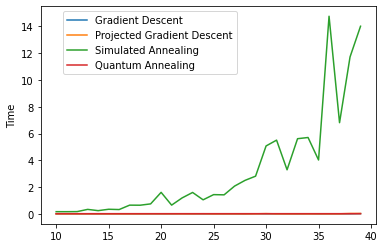

In [317]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(size,time_GD,label='Gradient Descent')
plt.plot(size,time_PGD,label='Projected Gradient Descent')
plt.plot(size,time_SA,label='Simulated Annealing')
plt.plot(size,time_QA,label='Quantum Annealing')
# plt.xlabel('Number of weights')
plt.ylabel('Time')

plt.legend(bbox_to_anchor=(0.6, 1))

plt.show()

#### Time Comparison without slowest simualted annealing

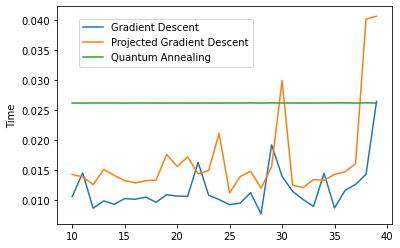

In [305]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(size,time_GD,label='Gradient Descent')
plt.plot(size,time_PGD,label='Projected Gradient Descent')
# plt.plot(size,time_SA,label='Simulated Annealing')
plt.plot(size,time_QA,label='Quantum Annealing')
# plt.xlabel('Number of weights')
plt.ylabel('Time')

plt.legend(bbox_to_anchor=(0.6, 0.7))

plt.show()

## Now let's see the accuaracy of returned weights from those algorithms

#### Error Comparison

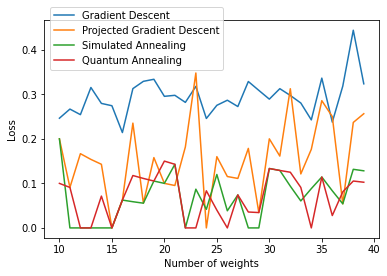

In [312]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(size,GD_error,label='Gradient Descent')
plt.plot(size,PGD_error,label='Projected Gradient Descent')
plt.plot(size,SA_error,label='Simulated Annealing')
plt.plot(size,QA_error,label='Quantum Annealing')
plt.xlabel('Number of weights')
plt.ylabel('Loss')


plt.legend(bbox_to_anchor=(0.55, 0.75))

plt.show()